# 5G UE-VBS Selection ML Model

## Simulation of UEs and Dataset Generation

In this notebook, we will generate the dataset to build the classification model. This model will determine if a User Equipment (UE) can become a 5G Virtual Base Station (VBS) or not.

* <strong>Environment setup:</strong> import libraries and load the dataset
* <strong>Simulation:</strong> Generating the Co-ordinates of the UEs
* <strong>Clustering:</strong> the UEs based on Distance from the Base Station
* <strong>Dataset Generation:</strong> for classification

## Environment Setup

In [1]:
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
import os
import shutil

directories = ['./Data', './Fig', './Eps', './Classifiers', './SMOTE']

# create directories if they don't exist
for directory in directories:
    try:
        os.mkdir(directory)
    except OSError as error:
        print(error)
#         pass
        
shutil.copy('master_simulation_1000_2500.csv', './Data/')

[WinError 183] Cannot create a file when that file already exists: './Data'
[WinError 183] Cannot create a file when that file already exists: './Trial'
[WinError 183] Cannot create a file when that file already exists: './Fig'
[WinError 183] Cannot create a file when that file already exists: './Eps'
[WinError 183] Cannot create a file when that file already exists: './Classifiers'
[WinError 183] Cannot create a file when that file already exists: './SMOTE'


'./Data/master_simulation_1000_2500.csv'

## Generating the Co-ordinates of the UEs


### Helper for generating the co-ordinates


In [3]:
def get_coordinates(number_of_ue_devices = 100, max_range=100):
    # default number of UE devices = 100
    coordinates = []

    for i in range(number_of_ue_devices):
        # Return the next random floating point number in the range [0.0, 1.0) - random.random()
        # By multiplying with 1000, the effective range shifts to [0, 1000) 
        coordinates.append([(random.random() * max_range), (random.random() * max_range)])
    return np.array(coordinates)

In [4]:
# initial coordinates at T1
number_of_ue_devices = 100
max_range = 1000
c = get_coordinates(number_of_ue_devices, max_range)

# Constant Parameters for propogation

dt = 20 #time interval
speed = [ random.randint(-10, 10) for _ in range(number_of_ue_devices) ]; # random speeds
angle =  [ random.randint(10, 350) for _ in range(number_of_ue_devices)] ; # random angles

# Base-Station Coordintes 
base_station_coordinates = [[500, 500]]

# At Time-0
x_1 = np.array([ i[0] for i in c ])
y_1 = np.array([ i[1] for i in c ])

# At Time-1
x_2 = [ x_1[i] + (speed[i] * dt) for i in range(number_of_ue_devices)]
y_2 = [ y_1[i] + (math.cos(angle[i]) * math.pi / 180) * dt for i in range(number_of_ue_devices)]

# At Time-2
x_3 = [ x_2[i] + (speed[i] * dt) for i in range(number_of_ue_devices)]
y_3 = [ y_2[i] + (math.cos(angle[i]) * math.pi / 180) * dt for i in range(number_of_ue_devices)]

### Visualizing the movement of the UEs

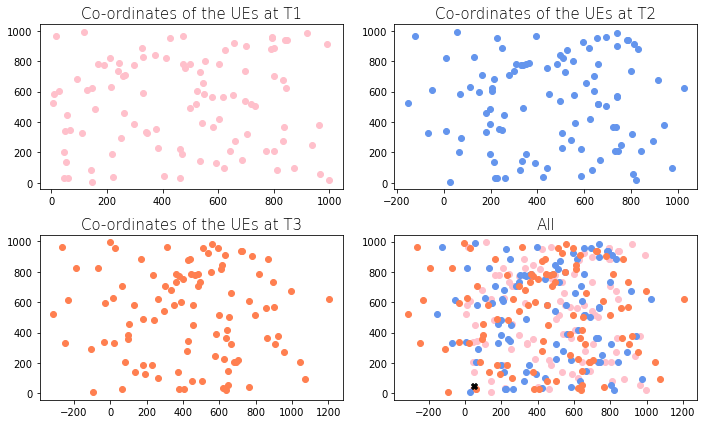

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
# fig.suptitle("Visualizing the movement of the UEs", fontsize='20', fontweight='light')
axs[0, 0].scatter(x_1, y_1, c='pink')
axs[0, 0].set_title("Co-ordinates of the UEs at T1", fontsize='15', fontweight='light')
axs[0, 1].scatter(x_2, y_2, c='cornflowerblue')
axs[0, 1].set_title("Co-ordinates of the UEs at T2", fontsize='15', fontweight='light')
axs[1, 0].scatter(x_3, y_3, c='coral')
axs[1, 0].set_title("Co-ordinates of the UEs at T3", fontsize='15', fontweight='light')
axs[1, 1].scatter(x_1, y_1, c='pink')
axs[1, 1].scatter(x_2, y_2, c='cornflowerblue')
axs[1, 1].scatter(x_3, y_3, c='coral')
axs[1, 1].scatter(50, 50, marker='X', c='black')
axs[1, 1].set_title("All", fontsize='15', fontweight='light')
fig.tight_layout()
plt.savefig("Fig/01-01-UE-Movement_in_Time_and_Space.png")
plt.savefig("Eps/01-01-UE-Movement_in_Time_and_Space.eps", format='eps')

## Clustering the UEs based on Distance from the Base Station

### Determining the ideal value for the number of clusters

The <strong>Silhouette Score</strong> and <strong>Silhouette Plot</strong> are used to measure the separation distance between clusters. It displays a measure of how close each point in a cluster is to points in the neighbouring clusters. This measure has a range of <strong>[-1, 1]</strong> and is a great tool to visually inspect the similarities within clusters and differences across clusters.<br>
<strong>Silhouette Score</strong> is calculated using the mean <strong>intra-cluster distance (i)</strong>
<strong>mean nearest-cluster distance (n)</strong> for each sample.<br>
The <strong>Silhouette Coefficient</strong> for a sample is <strong>(n - i) / max(i, n)</strong>.
- <strong>n</strong>: is the distance between each sample and the nearest cluster that the sample is not a part of
- <strong>i</strong>: is the mean distance within each cluster
    
Important Points about Silhouette Plots:
- The typical Silhouette Plots represent the cluster label on the y-axis, while the actual Silhouette Score on the x-axis
- The size/thickness of the silhouettes is also proportional to the number of samples inside that cluster
- The higher the Silhouette Coefficients (the closer to +1), the further away the cluster’s samples are from the neighbouring clusters samples
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighbouring clusters
- Negative values, instead, indicate that those samples might have been assigned to the wrong cluster
- Averaging the Silhouette Coefficients, we can get to a global Silhouette Score which can be used to describe the entire population’s performance with a single value

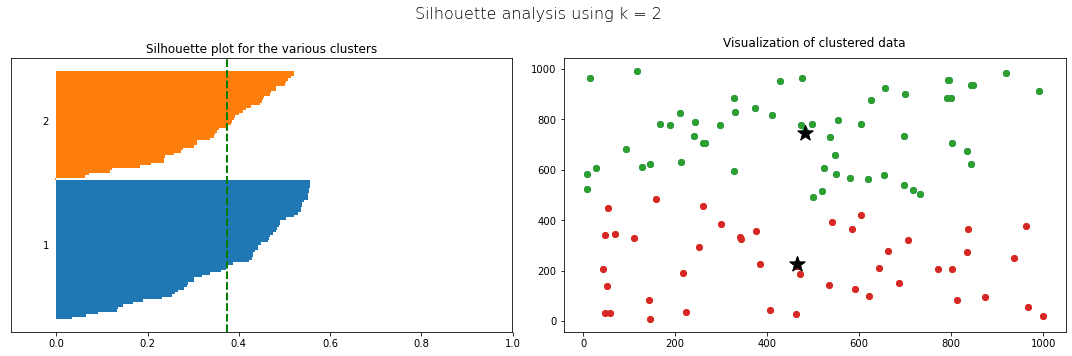

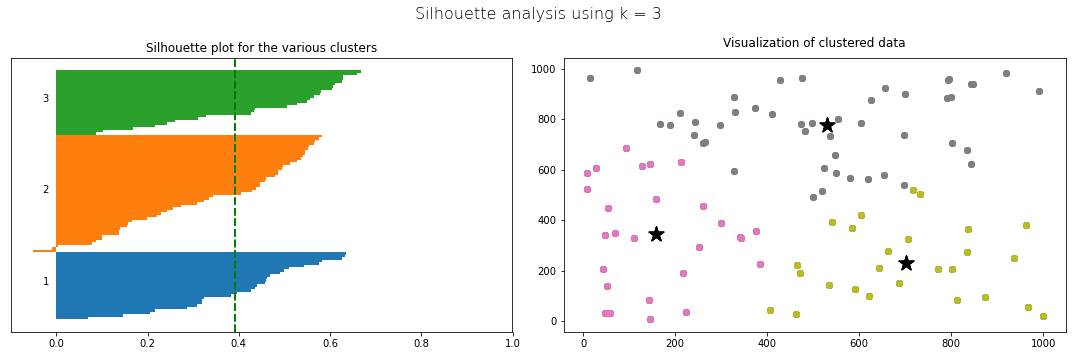

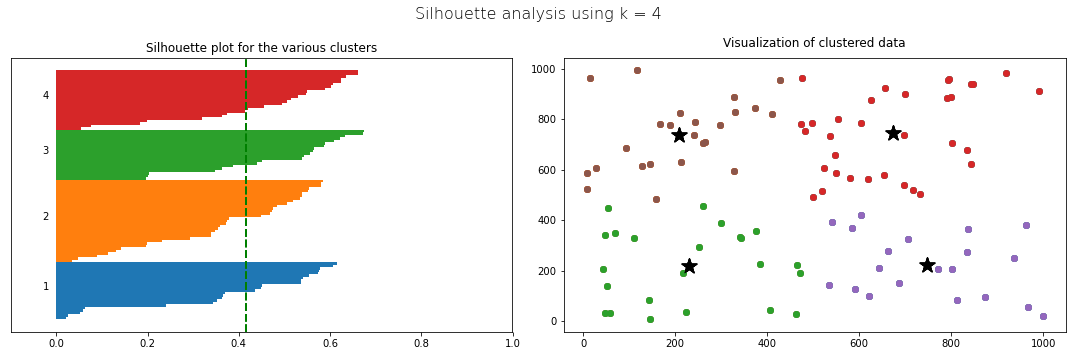

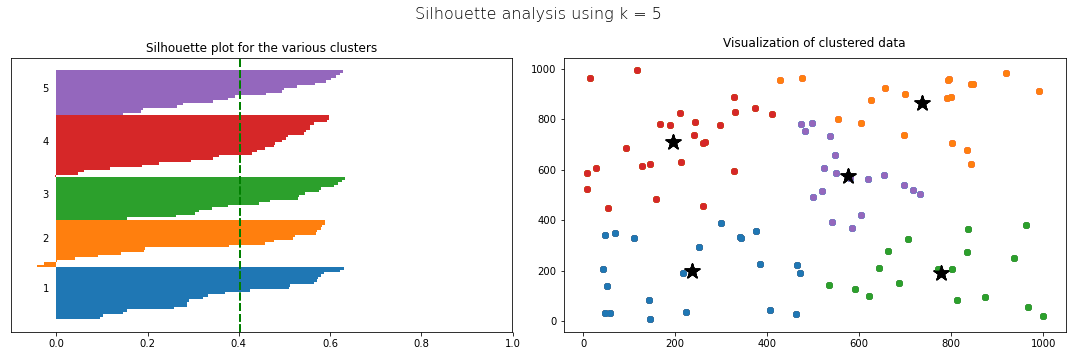

In [6]:
for i,k in enumerate([2,3,4,5]):
    
    fig, ax = plt.subplots(1,2,figsize=(15,5))

    # Run the kmeans algorithm
    km = KMeans(n_clusters=k)
    y_predict = km.fit_predict(c)
    centroids = np.unique(y_predict)
    
    # get silhouette
    silhouette_vals = silhouette_samples(c, y_predict)

    # silhouette plot
    y_ticks = []
    y_lower = y_upper = 0

    for i, cluster in enumerate(np.unique(y_predict)):
        cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        ax[0].barh(range(y_lower,y_upper), cluster_silhouette_vals,height =1);
        ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
        y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score 
        avg_score = np.mean(silhouette_vals)
        ax[0].axvline(avg_score,linestyle ='--', linewidth =2,color = 'green')
        ax[0].set_yticks([])
        ax[0].set_xlim([-0.1, 1])
        ax[0].set_title('Silhouette plot for the various clusters');


        # scatter plot of data colored with labels
        for cl in centroids:
            row_ix = np.where(y_predict == cl)
            ax[1].scatter(c[row_ix, 0], c[row_ix, 1])
            
        cl_centres = km.cluster_centers_
            
        ax[1].scatter(cl_centres[:, 0], cl_centres[:, 1], marker = '*' , c= 'black',s =250);
        ax[1].set_title('Visualization of clustered data', y=1.02)

        plt.tight_layout()
        plt.suptitle(f' Silhouette analysis using k = {k}',fontsize=16, fontweight = 'light')
    #     plt.savefig(f'Silhouette_analysis_{k}.jpg')

### K-Means

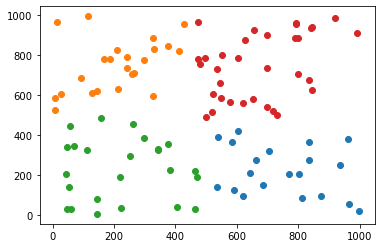

In [7]:
model_1 = KMeans(n_clusters=4)
model_1.fit(c)
yhat_1 = model_1.predict(c)
clusters_1 = np.unique(yhat_1)

fig = plt.figure()
for cluster in clusters_1:
    row_ix = np.where(yhat_1 == cluster)
    plt.scatter(c[row_ix, 0], c[row_ix, 1])

plt.show()
fig.savefig("Fig/01-02-KMeans_Clustering.png")
fig.savefig("Eps/01-02-KMeans_Clustering.eps", format='eps')

### Mean Shift

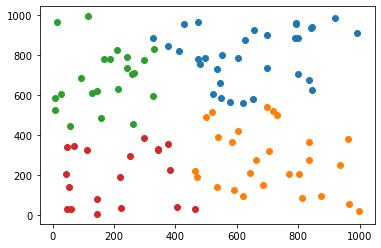

In [8]:
# hyper-parameter: bandwidth: for further documentation -> https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html?highlight=meanshift#sklearn.cluster.MeanShift
bandwidth = estimate_bandwidth(c, quantile=0.2, n_samples=number_of_ue_devices)

model_2 = MeanShift(bandwidth=bandwidth)
yhat_2 = model_2.fit_predict(c) # various cluster ids

clusters_2 = np.unique(yhat_2)

fig = plt.figure()
for cluster in clusters_2:
	row_ix = np.where(yhat_2 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])    

plt.show()
fig.savefig("Fig/01-03-Mean_Shift_Clustering.png")
fig.savefig("Eps/01-03-Mean_Shift_Clustering.eps", format='eps')

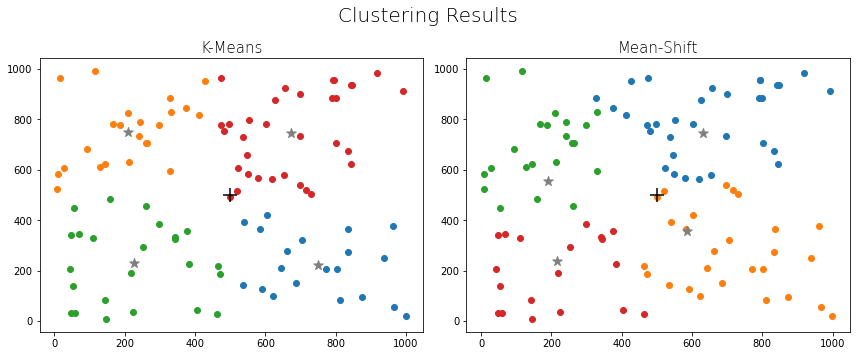

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Clustering Results", fontsize='20', fontweight='light')

# K-Means
ax1.set_title("K-Means", fontsize='15', fontweight='light')

for cluster in clusters_1:
    row_ix = np.where(yhat_1 == cluster)
    ax1.scatter(c[row_ix, 0], c[row_ix, 1])

# Cluster Centers
ax1.scatter(model_1.cluster_centers_[:, 0], model_1.cluster_centers_[:, 1], s=100, c='grey', marker='*')
# Base Station
ax1.scatter(500, 500, s=200, c='black', marker="+")

# Mean-Shift
ax2.set_title("Mean-Shift", fontsize='15', fontweight='light')

for cluster in clusters_2:
    row_ix = np.where(yhat_2 == cluster)
    ax2.scatter(c[row_ix, 0], c[row_ix, 1])

# Cluster Centers
ax2.scatter(model_2.cluster_centers_[:, 0], model_2.cluster_centers_[:, 1], s=100, c='grey', marker='*')
    
# Base Stattion
ax2.scatter(500, 500, s=200, c='black', marker="+")
fig.tight_layout()

fig.savefig("Fig/01-04-KMeans_and_Mean_Shift_Clustering.png")
fig.savefig("Eps/01-04-KMeans_and_Mean_Shift_Clustering.eps", format='eps')

### Performace comaparison between Mean-Shift and K-Means


In [10]:
print("K-Means Silhouette Score for k=4: ", silhouette_score(c, yhat_1, metric='euclidean'))
print("Mean Shift Silhouette Score: ", silhouette_score(c, yhat_2, metric='euclidean'))

K-Means Silhouette Score for k=4:  0.41552454381024523
Mean Shift Silhouette Score:  0.395769473218822


## Dataset Generation


### Parameters used in the log-normal path loss model

In [11]:
# Battery information 
instantanous_battery_amount = np.array([ (random.random() * 400) + 500 for _ in range(number_of_ue_devices) ]) 
decay = np.array([ random.randrange(1, 15) + 5 for _ in range(number_of_ue_devices) ])
battery_discharge_rate = np.array(instantanous_battery_amount/decay)

_alpha = 0.5
_beta = 0.5
_lambda = 4

# Parameters used in the log-normal path loss model 

speed_of_light = 3e8 
frequency = 5e9
frequency_4g = 1.9e9
wavelength = speed_of_light / frequency
wavelength_4g= speed_of_light / frequency_4g

dref = 10;
tx_antenna_gain = 1 # db
rx_antenna_gain = 1 # db
tx_power = 0.25; # watt
path_loss_exponent = 4 # Line Of sight
PTxdBm = 10 * math.log10(tx_power*1000); # db <-> watt conversion
gaussian_random_variable = np.random.randn() * 0.1
standard_base_station_power = 43

sigma = 6; # Sigma from 6 to 12 - Principles of communication systems simulation with wireless application P.548
distance_msr = 60;

# to calculate data rate (noisy channel)
# data_rate = bandwidth * log2(1 + SNR) bits/sec
# bandwidth = 800 MHz -> https://blogs.keysight.com/blogs/inds.entry.html/2018/10/31/understanding_5gnew-iYIV.html

### Adding Primary Parameters
1. Distance from base station 
2. Battery Discharge Rates
3. Power 

In [12]:
# cluster-wise seperation
clusters = np.unique(yhat_2)
df = pd.DataFrame(columns = ['x', 'y', 'cluster_number', 'distance_from_base_station', 'battery_discharge_rate'])
for cluster in clusters:
    # temp dataframe
    df2 = pd.DataFrame(columns = ['x', 'y', 'cluster_number', 'distance_from_base_station', 'battery_discharge_rate'])

    # indices corresponding each cluster
    row_ix = np.where(yhat_2 == cluster)

    # cluster number
    df2['cluster_number'] = np.array([cluster] * len(row_ix[0]))

    # storing the coordinates
    df2['x'] = c[row_ix, 0].reshape(-1)
    df2['y'] = c[row_ix, 1].reshape(-1)

    # storing the distances
    df2['distance_from_base_station'] = cdist(c[row_ix], base_station_coordinates)

    # battery dischage rate
    df2['battery_discharge_rate'] = battery_discharge_rate[row_ix]

    df = df.append(df2, ignore_index = True)

In [13]:
# power from the base station 
df['M'] = wavelength / ( 4 * math.pi * df['distance_from_base_station'] ) 
df['pr0'] = standard_base_station_power + PTxdBm + tx_antenna_gain + rx_antenna_gain - np.array([ 20 * math.log10(i) for i in (1 / df['M']) ])
df['power'] = df['pr0'] - ( 10 * path_loss_exponent * math.log10(1/dref) ) + gaussian_random_variable

# master parameter 
df['master_parameter'] = _alpha * df['power'] + _beta * df['battery_discharge_rate']

In [14]:
# mobile configurations
possible_rams = [4, 6, 8, 12, 16]
df['memory'] = [ possible_rams[random.randrange(0, 4)] for _ in range(number_of_ue_devices) ] 

df['cpu_power'] = [ random.random() * 100 for _ in range(number_of_ue_devices) ]

In [15]:
# Previous Method

# Selection of eligible UE using master_parameter
# cluster_means = []

# for cluster in clusters:
#   cluster_means.append(df[df['cluster_number'] == cluster]['master_parameter'].mean())

# cluster_means = np.array(cluster_means)

# df['eligibility'] = df['master_parameter'] > cluster_means[list(df['cluster_number'])]

## Adding additional parameters 
1. Data Rate
2. QoE
3. QoS

In [16]:
df

,x,y,cluster_number,distance_from_base_station,battery_discharge_rate,M,pr0,power,master_parameter,memory,cpu_power
0,579.290839,568.070537,0,104.501843,43.681927,0.000046,-17.824251,22.292899,32.987413,8,0.368672
1,655.583396,923.816620,0,451.471727,52.962181,0.000011,-30.534383,9.582767,31.272474,6,22.639912
2,991.407144,912.081070,0,641.320349,58.190389,0.000007,-33.583273,6.533878,32.362134,12,69.694647
3,374.393550,844.850426,0,367.013346,55.435890,0.000013,-28.735409,11.381741,33.408816,12,19.978461
4,481.337789,753.228695,0,253.915439,46.508656,0.000019,-25.535554,14.581596,30.545126,6,98.089775
...,...,...,...,...,...,...,...,...,...,...,...
95,68.752728,347.402025,3,457.449835,58.706515,0.000010,-30.648642,9.468509,34.087512,4,41.991330
96,251.811650,294.064249,3,322.501148,89.271565,0.000015,-27.612397,12.504753,50.888159,6,62.431139
97,59.285588,30.263004,3,644.113374,41.161181,0.000007,-33.621019,6.496132,23.828657,4,61.965649
98,110.473324,328.070634,3,425.782501,110.385309,0.000011,-30.025528,10.091622,60.238466,6,66.080629


In [17]:
def signal_to_noise_ratio(ue_vbs, ue_device, cluster, power):
  # Sending index of eUE, its position, position of receiving UE and received power
    
    hnm = np.random.randn() + np.random.randn()*j # Rayleigh Fading Channel
    _lambda = 4
    dr = []
    gaussian_random = np.random.randn()*0.1 + 0
    nvar = -174+10 * math.log10(100e7)

    for i, row_i in cluster.iterrows():
#         if row_i.all() != ue_device.all() and row_i.all() != ue_vbs.all():
        rtm = ( (row_i['x'] - ue_device['x'])**2 + (row_i['y'] - ue_device['y'])**2 ) ** 0.5
        if rtm == 0:
            continue
        m = wavelength / ( 4 * math.pi * rtm )
        pr0 = row_i['power'] + tx_antenna_gain + rx_antenna_gain + ( 20 * math.log10(1/m) )
        prx = pr0 - ( 10 * path_loss_exponent * math.log10(1/dref) ) + gaussian_random
        rn = nvar + np.random.randn() + np.random.randn()*j * row_i['power'] * _lambda * (rtm**(-1*_lambda))
        dr.append(rn)
  
#     print(dr)
    inter = sum(dr)
    rnm = ( (ue_vbs['x'] - ue_device['x'])**2 + (ue_vbs['y'] - ue_device['y'])**2 ) ** 0.5
    if rnm == 0: return 0
    sign = hnm * power * _lambda * ( rnm ** (-1 * _lambda) )

    s = abs(sign/inter)
    return s

In [18]:
def spaceff(p1, p2, cluster):
    x = []
    for i, ue in cluster.iterrows():
        x.append(ue['power'])

    sx = sum(x)
    sx = (sx - p2) * 0.4292
    c2 = (p1 * 0.4292) / (p2 * 0.4292 + sx + 1)
    se = math.log2( 1 + c2 )

    return se

In [19]:
def max_mean(arr):
  # replaces sumsinr and sumse
    t = []
    for i in arr:
        t.append(i.mean())

    return max(t)

In [20]:
def quality_of_service(idx, cluster):
    x = []
    for i in cluster:
        x.append(i[idx])
    x = np.array(x)
    x = x/x.mean()

    return 1/(1+(x.var()/x.mean()))

In [21]:
def quality_of_experience(idx, cluster):
    x = []
    for i in cluster:
        x.append(i[idx])
    x = np.array(x)
    _sigma = np.std(x)

    return (2*_sigma)/(max(x) - min(x))

In [22]:
# Seperation of clusters

clusters_seperated = []
for cluster in clusters:
    clusters_seperated.append(df[df['cluster_number'] == cluster])

In [23]:
# # previous version : using master_parameter

# for cluster in clusters_seperated:
#   eligible_devices = cluster[cluster['eligibility']]
#   ss = []
#   sp = []

#   for i, row_i in eligible_devices.iterrows():
#     for j, row_j in cluster.iterrows():
#       if i != j:
#         distance_from_eligible_ue = ( (row_i['x'] - row_j['x'])**2 + (row_i['y'] - row_j['y'])**2 )**0.5
#         m = wavelength / ( 4 * math.pi * distance_from_eligible_ue )
#         pr0 = row_i['power'] + tx_antenna_gain + rx_antenna_gain + ( 20 * math.log10(1/m) )
#         prx = pr0 - ( 10 * path_loss_exponent * math.log10(1/dref) ) + gaussian_random_variable
#         s = signal_to_noise_ratio(row_i, row_j, cluster, prx)
#         ss.append(s)
#         se = spaceff(prx, row_i['power'], cluster)
#         sp.append(se)
#       else:
#         ss.append(0);
#         sp.append(0)

#   ss1 = np.array(ss).reshape(len(eligible_devices), len(cluster))
#   sp1 = np.array(sp).reshape(len(eligible_devices), len(cluster))

#   # tss1 = max_mean(ss1)
#   tsp1 = max_mean(sp1)

#   # l = quality_of_service(tsp1, sp1)
#   # print(tss1, tsp1, l)

In [24]:
qos_final = []
snr_final = []
qoe_final = []
for cluster in clusters_seperated:
    ss = []
    sp = []

    for i, row_i in cluster.iterrows():
        for j, row_j in cluster.iterrows():
            if i != j:
                distance_from_eligible_ue = ( (row_i['x'] - row_j['x'])**2 + (row_i['y'] - row_j['y'])**2 )**0.5
                m = wavelength / ( 4 * math.pi * distance_from_eligible_ue )
                pr0 = row_i['power'] + tx_antenna_gain + rx_antenna_gain + ( 20 * math.log10(1/m) )
                prx = pr0 - ( 10 * path_loss_exponent * math.log10(1/dref) ) + gaussian_random_variable
                s = signal_to_noise_ratio(row_i, row_j, cluster, prx)
                ss.append(s)
                se = spaceff(prx, row_i['power'], cluster)
                sp.append(se)
            else:
                ss.append(0);
                sp.append(0)

    ss1 = np.array(ss).reshape(len(cluster), len(cluster))
    sp1 = np.array(sp).reshape(len(cluster), len(cluster))

    qos = []
    for i in range(len(sp1)):
        qos.append(quality_of_service(i, sp1))

    qoe = []
    for i in range(len(sp1)):
        qoe.append(quality_of_experience(i, sp1))

    snr = []
    for i in ss1:
        snr.append(max_mean(i))

    snr_final.extend(snr)
    qos_final.extend(qos)
    qoe_final.extend(qoe)

df['qos'] = qos_final
df['qoe'] = qoe_final
df['snr'] = snr_final
df['data_rate'] = [ 100e7 * math.log2(1 + i) for i in df['snr'] ]

In [25]:
final = df.drop(['cluster_number', 'M', 'pr0', 'snr'],axis=1)
final['master_parameter'] = 0.01 * final['data_rate'] + 0.5 * final['power'] + 0.5 * final['battery_discharge_rate'] + 0.5 * final['cpu_power'] + final['memory']

In [26]:
# identify outliers with standard deviation
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
# seed the random number generator
seed(1)
# generate univariate observations
data = final['master_parameter']
# calculate summary statistics
data_mean, data_std = np.mean(data), np.std(data)
# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Identified outliers: 3
Non-outlier observations: 97


In [27]:
final['eligibility'] = final['master_parameter'] > np.array(outliers_removed).mean()

In [28]:
final

,x,y,distance_from_base_station,battery_discharge_rate,power,master_parameter,memory,cpu_power,qos,qoe,data_rate,eligibility
0,579.290839,568.070537,104.501843,43.681927,22.292899,88.473970,8,0.368672,0.968580,0.344283,4.730222e+03,False
1,655.583396,923.816620,451.471727,52.962181,9.582767,52.133276,6,22.639912,0.966924,0.330537,3.540846e+02,False
2,991.407144,912.081070,641.320349,58.190389,6.533878,79.478309,12,69.694647,0.966844,0.333179,2.688524e+01,False
3,374.393550,844.850426,367.013346,55.435890,11.381741,91.979230,12,19.978461,0.967343,0.333521,3.658118e+03,False
4,481.337789,753.228695,253.915439,46.508656,14.581596,361.466801,6,98.089775,0.967559,0.334767,2.758768e+04,False
...,...,...,...,...,...,...,...,...,...,...,...,...
95,68.752728,347.402025,457.449835,58.706515,9.468509,1357.443294,4,41.991330,0.945828,0.431949,1.298360e+05,False
96,251.811650,294.064249,322.501148,89.271565,12.504753,99.506477,6,62.431139,0.947256,0.437924,1.140275e+03,False
97,59.285588,30.263004,644.113374,41.161181,6.496132,33113.122757,4,61.965649,0.944601,0.429877,3.305431e+06,True
98,110.473324,328.070634,425.782501,110.385309,10.091622,126.925594,6,66.080629,0.946405,0.431116,2.764681e+03,False


In [29]:
final.drop(['master_parameter'], axis=1)

,x,y,distance_from_base_station,battery_discharge_rate,power,memory,cpu_power,qos,qoe,data_rate,eligibility
0,579.290839,568.070537,104.501843,43.681927,22.292899,8,0.368672,0.968580,0.344283,4.730222e+03,False
1,655.583396,923.816620,451.471727,52.962181,9.582767,6,22.639912,0.966924,0.330537,3.540846e+02,False
2,991.407144,912.081070,641.320349,58.190389,6.533878,12,69.694647,0.966844,0.333179,2.688524e+01,False
3,374.393550,844.850426,367.013346,55.435890,11.381741,12,19.978461,0.967343,0.333521,3.658118e+03,False
4,481.337789,753.228695,253.915439,46.508656,14.581596,6,98.089775,0.967559,0.334767,2.758768e+04,False
...,...,...,...,...,...,...,...,...,...,...,...
95,68.752728,347.402025,457.449835,58.706515,9.468509,4,41.991330,0.945828,0.431949,1.298360e+05,False
96,251.811650,294.064249,322.501148,89.271565,12.504753,6,62.431139,0.947256,0.437924,1.140275e+03,False
97,59.285588,30.263004,644.113374,41.161181,6.496132,4,61.965649,0.944601,0.429877,3.305431e+06,True
98,110.473324,328.070634,425.782501,110.385309,10.091622,6,66.080629,0.946405,0.431116,2.764681e+03,False


In [30]:
final

,x,y,distance_from_base_station,battery_discharge_rate,power,master_parameter,memory,cpu_power,qos,qoe,data_rate,eligibility
0,579.290839,568.070537,104.501843,43.681927,22.292899,88.473970,8,0.368672,0.968580,0.344283,4.730222e+03,False
1,655.583396,923.816620,451.471727,52.962181,9.582767,52.133276,6,22.639912,0.966924,0.330537,3.540846e+02,False
2,991.407144,912.081070,641.320349,58.190389,6.533878,79.478309,12,69.694647,0.966844,0.333179,2.688524e+01,False
3,374.393550,844.850426,367.013346,55.435890,11.381741,91.979230,12,19.978461,0.967343,0.333521,3.658118e+03,False
4,481.337789,753.228695,253.915439,46.508656,14.581596,361.466801,6,98.089775,0.967559,0.334767,2.758768e+04,False
...,...,...,...,...,...,...,...,...,...,...,...,...
95,68.752728,347.402025,457.449835,58.706515,9.468509,1357.443294,4,41.991330,0.945828,0.431949,1.298360e+05,False
96,251.811650,294.064249,322.501148,89.271565,12.504753,99.506477,6,62.431139,0.947256,0.437924,1.140275e+03,False
97,59.285588,30.263004,644.113374,41.161181,6.496132,33113.122757,4,61.965649,0.944601,0.429877,3.305431e+06,True
98,110.473324,328.070634,425.782501,110.385309,10.091622,126.925594,6,66.080629,0.946405,0.431116,2.764681e+03,False


In [31]:
# df1 = pd.read_csv('./Trial/simulation_1000.csv', index_col=0)
# df1 = df1.drop(['master_parameter'], axis=1)
# df1
# df2 = pd.read_csv('./Data/master_dataset.csv', index_col=None)
# df2
# df3 = pd.read_csv('./Trial/simulation_2500.csv', index_col=0)
# df3
# print(df1.shape)
# print(df2.shape)
# print(df3.shape)
# li = [df1, df2, df3]
# frame = pd.concat(li, axis=0, ignore_index=True)
# frame
# import missingno as msno
# print(msno.matrix(frame))
# frame.to_csv('./Trial/master_simulation_1000_2500.csv')